#  Spectral unmixing in chemometrics: Workshop

Workshop, December 5th, 2024  
Chungnam  National university  

Software program performs spectral unmixing with;    
 
(a) Multivariate Curve Resolution - Alternating Least Squares (MCR-ALS)  

(b) Multivariate Curve Resolution - Non-negativity Least Squares (MCR-NNLS) 

@ Semyalo Dennis  
LinkedIn: https://www.linkedin.com/in/semyalo-dennis-5471b4158/  
Google scholar: https://scholar.google.com/citations?user=0_jvpccAAAAJ&hl=en  
Email: semyalod@gmail.com

In [6]:
# Import the datetime module for handling date and time operations
import datetime

# Import NumPy, a fundamental package for numerical computations in Python
import numpy as np 

# Import the svds function for computing the singular value decomposition of sparse matrices
from scipy.sparse.linalg import svds

# Import Matplotlib's pyplot module for creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt

# Configure Matplotlib to display plots inline within Jupyter notebooks
%matplotlib inline

# Set the resolution of saved figures to 300 dots per inch (DPI) for high-quality images
plt.rcParams['savefig.dpi'] = 300

# Set the default font size for plot text elements to 10 points
plt.rcParams['font.size'] = 10

# Set the default font size for plot legends to 8 points
plt.rcParams['legend.fontsize'] = 8

# Import specific components from the pymcr library for Multivariate Curve Resolution (MCR) analysis

# Import the McrAR class, which implements the Alternating Regression (AR) algorithm for MCR
import pymcr
from pymcr.mcr import McrAR

# Import Ordinary Least Squares (OLS) and Non-Negative Least Squares (NNLS) regressors
from pymcr.regressors import OLS, NNLS

# Import constraints to enforce non-negativity and normalization in the MCR model
from pymcr.constraints import ConstraintNonneg, ConstraintNorm

# Import the mean squared error (MSE) metric for evaluating model performance
from pymcr.metrics import mse

# Import the base Constraint class for defining custom constraints if needed
from pymcr.constraints import Constraint

# Import the default_timer from the timeit module to measure execution time of code snippets
from timeit import default_timer as timer


In [7]:
#check pymcr version
print(pymcr.__version__)


0.5.1


# Parameters

In [8]:

# -----------------------------------------------------------
# Configuration Settings for Figure Saving and Randomness
# -----------------------------------------------------------

# Flag to determine whether figures generated during the analysis should be saved to disk.
# Setting this to True enables the saving of figures, while setting it to False disables it.
SAVEFIG = True

# Prefix used for naming saved figure files.
# This helps in organizing and identifying figures related to this specific analysis or model.
fig_prefix = 'MCR-AR_Model2'

# Obtain the current date and time.
# This timestamp will be used to uniquely identify saved figures, preventing filename conflicts
# and providing information about when the figures were generated.
now = datetime.datetime.now()

# Format the current date and time into a string to create a standardized prefix for filenames.
# The format '%y%m%d_%H%M' breaks down as follows:
# - %y: Two-digit year (e.g., '24' for 2024)
# - %m: Two-digit month (e.g., '11' for November)
# - %d: Two-digit day of the month (e.g., '16')
# - %H: Two-digit hour in 24-hour format (e.g., '14' for 2 PM)
# - %M: Two-digit minute (e.g., '30')
# This results in a string like '241116_1430', which can be used as a timestamp prefix.
date_prefix = now.strftime('%y%m%d_%H%M')

# Set the seed for NumPy's random number generator.
# This ensures that any random operations performed by NumPy produce the same results each time the script is run,
# which is essential for reproducibility, especially in scientific computations and analyses.
np.random.seed(0)


# Define model system

## Initial spectal components

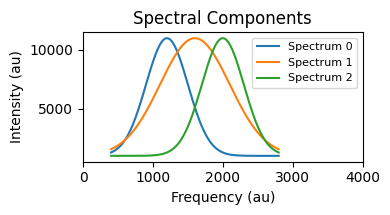

In [9]:

# Generate an array of wavenumbers (frequency) ranging from 400 to 2800 with 200 points
wn = np.linspace(400, 2800, 200)

# Define the number of spectral components to unmix
n_components = 3

# Generate synthetic Spectrum 0: A Gaussian peak centered at 1200 with a standard deviation of 300, scaled by 1e4, plus a baseline of 1000
#f(x) = a * np.exp(-((x - b) ** 2) / (2 * c ** 2)) + baseline
# f(x) is the gaussian function (y)
# x is the input independent values
# a is the amplitude (height of the peak)
# b is the center position of the peak
# c is the standard deviation, controlling the width of the curve
sp0 = 1e4 * np.exp(-((wn - 1200) ** 2) / (2 * 300 ** 2)) + 1000
#f(x)=sp0, x=wn, a=1e4, b=1200, c=300, baseline=1000

# Generate synthetic Spectrum 1: A Gaussian peak centered at 1600 with a standard deviation of 500, scaled by 1e4, plus a baseline of 1000
sp1 = 1e4 * np.exp(-((wn - 1600) ** 2) / (2 * 500 ** 2)) + 1000

# Generate synthetic Spectrum 2: A Gaussian peak centered at 2000 with a standard deviation of 300, scaled by 1e4, plus a baseline of 1000
sp2 = 1e4 * np.exp(-((wn - 2000) ** 2) / (2 * 300 ** 2)) + 1000

# Initialize a new figure for plotting with a specified size (width=4 inches, height=2.25 inches)
plt.figure(figsize=[4, 2.25])
# Plot Spectrum 0 with wavenumber on the x-axis and intensity on the y-axis, labeled as 'Spectrum 0'
plt.plot(wn, sp0, label='Spectrum 0')
# Plot Spectrum 1 with wavenumber on the x-axis and intensity on the y-axis, labeled as 'Spectrum 1'
plt.plot(wn, sp1, label='Spectrum 1')
# Plot Spectrum 2 with wavenumber on the x-axis and intensity on the y-axis, labeled as 'Spectrum 2'
plt.plot(wn, sp2, label='Spectrum 2')
# Set the label for the x-axis as 'Frequency (au)'
plt.xlabel('Frequency (au)')
# Set the label for the y-axis as 'Intensity (au)'
plt.ylabel('Intensity (au)')
# Add a legend to the plot, automatically placing it in the best location
plt.legend(loc='best')
# Set the title of the plot to 'Spectral Components'
plt.title('Spectral Components')
# Set the x-axis limits to range from 0 to 4000 au
plt.axis(xmin=0, xmax=4000)
# Adjust the padding of the plot to fit elements tightly within the figure
plt.tight_layout()
# Check if the SAVEFIG flag is True; if so, save the figure as a png file with a formatted filename
if SAVEFIG:
    plt.savefig('./{}_{}_Model_Spectra.png'.format(date_prefix, fig_prefix))



## Concentration map

Model starts off as 3 2D-Gaussian centered at (x*, y*) with standard deviation R (1 for each component).

The sum to 1 constraint is then enforced.

In [10]:

# Define the x and y coordinates for the center of the first Gaussian component
x0 = 10
y0 = 10

# Define the x and y coordinates for the center of the second Gaussian component
x1 = 90
y1 = 10

# Define the x and y coordinates for the center of the third Gaussian component
x2 = 50
y2 = 50

# Define the standard deviation (radius) for the first Gaussian component
R0 = 20
# Define the standard deviation (radius) for the second Gaussian component
R1 = 20
# Define the standard deviation (radius) for the third Gaussian component
R2 = 20

# Define the number of rows (Y-axis) in the concentration map
M = 50  # rows (Y)
# Define the number of columns (X-axis) in the concentration map
N = 100  # cols (X)

# Initialize the concentration map with zeros
# The shape is (M, N, n_components), where n_components is the number of spectral components
conc = np.zeros((M, N, n_components))
print("conc shape:", conc.shape)  # Verify the dimensions

# Create coordinate matrices for X and Y axes using meshgrid
# X has shape (M, N) where each row is [0, 1, 2, ..., N-1]
# Y has shape (M, N) where each column is [0, 1, 2, ..., M-1]
X, Y = np.meshgrid(np.arange(N), np.arange(M))

# Assign the first concentration component using a 2D Gaussian centered at (x0, y0) with radius R0
conc[..., 0] = np.exp(-((X - x0) ** 2) / (2 * R0 ** 2)) * np.exp(-((Y - y0) ** 2) / (2 * R0 ** 2))
# Assign the second concentration component using a 2D Gaussian centered at (x1, y1) with radius R1
conc[..., 1] = np.exp(-((X - x1) ** 2) / (2 * R1 ** 2)) * np.exp(-((Y - y1) ** 2) / (2 * R1 ** 2))
# Assign the third concentration component using a 2D Gaussian centered at (x2, y2) with radius R2
conc[..., 2] = np.exp(-((X - x2) ** 2) / (2 * R2 ** 2)) * np.exp(-((Y - y2) ** 2) / (2 * R2 ** 2))

# Normalize the concentration map so that the sum of concentrations across components equals 1 for each pixel
conc /= conc.sum(axis=-1)[:, :, None]

# The following loop ensures that each component has at least one "pure" pixel
# A pure pixel has a concentration of 1 for that component and 0 for others

# Iterate over each spectral component
for num in range(n_components):
    # Find the indices (row and column) where the concentration for the current component is >= 99.9% of its maximum value
    idx_m, idx_n = np.where(conc[..., num] >= 0.999 * conc[..., num].max())
    # Set all concentrations at these indices to 0 for all components
    conc[idx_m, idx_n, :] = 0
    # Set the concentration of the current component to 1 at these indices, making them pure pixels
    conc[idx_m, idx_n, num] = 1

# Re-normalize the concentration map to ensure that the sum across components remains 1 after introducing pure pixels
conc /= conc.sum(axis=-1)[:, :, None]
print("conc1 shape:", conc.shape)  # Verify the dimensions

conc shape: (50, 100, 3)
conc1 shape: (50, 100, 3)


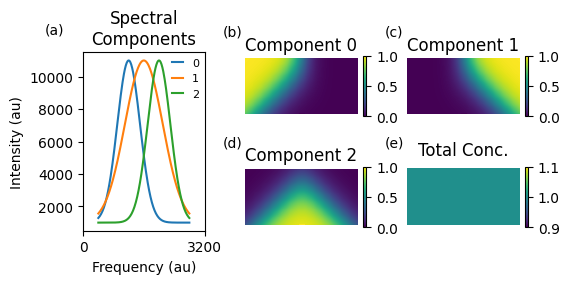

In [11]:

# Create a new figure with a specified size (width=5.5 inches, height=4 inches)
plt.figure(figsize=(5.5, 4))

# -------------------- Spectral Components Plot --------------------
# Create a subplot within a grid of 4 rows and 3 columns
# Position the subplot starting at row=1, column=0 and span 2 rows vertically
plt.subplot2grid((4, 3), loc=[1, 0], rowspan=2)

# Plot the first spectral component (sp0) against the wavenumber (wn)
plt.plot(wn, sp0, label='0')
# Plot the second spectral component (sp1) against the wavenumber (wn)
plt.plot(wn, sp1, label='1')
# Plot the third spectral component (sp2) against the wavenumber (wn)
plt.plot(wn, sp2, label='2')

# Set the label for the x-axis as 'Frequency (au)'
plt.xlabel('Frequency (au)')
# Set the label for the y-axis as 'Intensity (au)'
plt.ylabel('Intensity (au)')

# Add a legend to the plot located at the upper right corner
# Remove the frame around the legend, set padding between legend border and text to 0,
# and set the length of the legend handles (lines) to 1
plt.legend(loc='upper right', frameon=False, borderpad=0, handlelength=1)

# Set the title of the plot with a newline for formatting
plt.title('Spectral\nComponents')

# Optionally set the x-axis limits from 0 to 3000 (commented out)
# plt.axis(xmin=0, xmax=3000)

# Set the x-axis ticks to show only at 0 and 3200
plt.xticks((0, 3200))

# Add text annotation '(a)' at the position (-1000, 1.1 * ymax)
# plt.axis() returns [xmin, xmax, ymin, ymax], so plt.axis()[-1] is ymax
plt.text(-1000, 1.1 * plt.axis()[-1], '(a)')

# -------------------- Concentration Component 0 --------------------
# Create a subplot positioned at row=1, column=1 spanning 1 row
plt.subplot2grid((4, 3), loc=[1, 1], rowspan=1)

# Display the first concentration map using imshow
# conc[...,0] selects all rows and columns for the first component
plt.imshow(conc[..., 0])

# Add a colorbar to the image with a fraction of 0.025 relative to the plot size
plt.colorbar(fraction=0.025)

# Turn off the axis lines and labels for a cleaner look
plt.axis('off')

# Set the title of the subplot dynamically with the component number (0)
plt.title('Component {}'.format(0))

# Add text annotation '(b)' at the position (-20, -20) relative to the image
plt.text(-20, -20, '(b)')

# -------------------- Concentration Component 1 --------------------
# Create a subplot positioned at row=1, column=2 spanning 1 row
plt.subplot2grid((4, 3), loc=[1, 2], rowspan=1)

# Display the second concentration map using imshow
plt.imshow(conc[..., 1])

# Add a colorbar to the image with a fraction of 0.025 relative to the plot size
plt.colorbar(fraction=0.025)

# Turn off the axis lines and labels for a cleaner look
plt.axis('off')

# Set the title of the subplot dynamically with the component number (1)
plt.title('Component {}'.format(1))

# Add text annotation '(c)' at the position (-20, -20) relative to the image
plt.text(-20, -20, '(c)')

# -------------------- Concentration Component 2 --------------------
# Create a subplot positioned at row=2, column=1 spanning 1 row
plt.subplot2grid((4, 3), loc=[2, 1], rowspan=1)

# Display the third concentration map using imshow
plt.imshow(conc[..., 2])

# Add a colorbar to the image with a fraction of 0.025 relative to the plot size
plt.colorbar(fraction=0.025)

# Turn off the axis lines and labels for a cleaner look
plt.axis('off')

# Set the title of the subplot dynamically with the component number (2)
plt.title('Component {}'.format(2))

# Add text annotation '(d)' at the position (-20, -20) relative to the image
plt.text(-20, -20, '(d)')

# -------------------- Total Concentration Map --------------------
# Create a subplot positioned at row=2, column=2 spanning 1 row
plt.subplot2grid((4, 3), loc=[2, 2], rowspan=1)

# Display the sum of all concentration maps using imshow
# conc.sum(axis=-1) sums across the last axis, aggregating all components
# clim sets the color limits to [0.9, 1.1] for consistent scaling
plt.imshow(conc.sum(axis=-1), clim=[0.9, 1.1])

# Add a colorbar to the image with a fraction of 0.025 relative to the plot size
plt.colorbar(fraction=0.025)

# Turn off the axis lines and labels for a cleaner look
plt.axis('off')

# Ensure that the x and y axes have equal scaling
plt.axis('equal')

# Set the title of the subplot as 'Total Conc.'
plt.title('Total Conc.')

# Add text annotation '(e)' at the position (-20, -20) relative to the image
plt.text(-20, -20, '(e)')

# -------------------- Final Layout Adjustments --------------------
# Adjust the padding between and around subplots to prevent overlap
# pad=0: padding between the figure edge and the subplots
# h_pad=0: height padding between subplots
# w_pad=-1: width padding between subplots (negative to reduce space)
plt.tight_layout(pad=0, h_pad=0, w_pad=-1)

# -------------------- Save the Figure --------------------
# Check if the SAVEFIG flag is set to True to save the figure
if SAVEFIG:
    # Save the figure in png format with a filename constructed from date_prefix and fig_prefix
    plt.savefig('./{}_{}_Model_Conc_Spectra_Compound.png'.format(date_prefix, fig_prefix))


In [12]:

# A spatially-unraveled copy of conc for error calcs
#  reshape the concentration matrix conc into a two-dimensional array conc_ravel suitable for error calculations
conc_ravel = conc.reshape((-1, n_components))
print("conc_ravel shape:", conc_ravel.shape)  # Verify the dimensions

# Stack 3 spectral vectors into 1 matrix
# combine three separate spectral vectors into a single matrix called spectra
spectra = np.vstack((sp0, sp1, sp2))
print("spectra shape:", spectra.shape)  # Verify the dimensions

# Hyperspectral image (HSI)
# reconstruct the hyperspectral image (HSI) by combining the concentration of each component with their respective spectral signatures
hsi = np.dot(conc, spectra)
print("hsi shape:", hsi.shape)  # Verify the dimensions

# reshape the hyperspectral image and add random noise to simulate measurement errors or to test the robustness of the unmixing algorithm. 
# The commented line shows an alternative version without noise.
hsi_ravel = hsi.reshape((-1, wn.size)) + 250*np.random.randn(M*N,wn.size)
#hsi_ravel = hsi.reshape((-1, wn.size))
print("hsi_ravel shape:", hsi_ravel.shape)  # Verify the dimensions


conc_ravel shape: (5000, 3)
spectra shape: (3, 200)
hsi shape: (50, 100, 200)
hsi_ravel shape: (5000, 200)


## Spectral Guess/initial spectra estimate

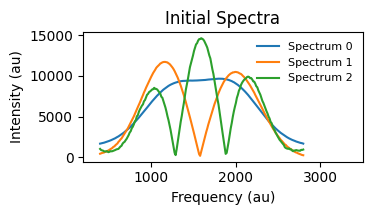

In [13]:
# Perform Singular Value Decomposition (SVD) on the reshaped hyperspectral image data
# hsi_ravel is assumed to be a 2D array where each row is a pixel's spectral data
# k=4 specifies the number of singular values and vectors to compute
U, s, Vh = svds(hsi_ravel, k=4)

# Sort the singular values in descending order and reorder the corresponding Vh rows
# np.argsort(s) returns the indices that would sort the singular values in ascending order
# np.flip(...) reverses the order to get descending
# [:-1] excludes the smallest singular value to possibly focus on the most significant components
Vh = Vh[np.flip(np.argsort(s))[:-1], :]

# Initialize the spectra by taking the absolute value of Vh to ensure non-negativity
# Normalize each spectrum by its maximum value to scale between 0 and 1
# Multiply by the maximum value of hsi_ravel to scale the initial spectra appropriately
initial_spectra = np.abs(Vh) / Vh.max() * hsi_ravel.max()

# Create a new figure for plotting with a specified size (width=4 inches, height=2.25 inches)
plt.figure(figsize=[4, 2.25])

# Plot the first initial spectrum against the wavelength (wn)
# initial_spectra[0, :] selects the first spectrum
# 'Spectrum 0' is the label for the legend
plt.plot(wn, initial_spectra[0, :], label='Spectrum 0')

# Plot the second initial spectrum
plt.plot(wn, initial_spectra[1, :], label='Spectrum 1')

# Plot the third initial spectrum
plt.plot(wn, initial_spectra[2, :], label='Spectrum 2')

# Set the x-axis label to 'Frequency (au)'
plt.xlabel('Frequency (au)')

# Set the y-axis label to 'Intensity (au)'
plt.ylabel('Intensity (au)')

# Add a legend to the plot
# loc='best' automatically places the legend in the optimal location
# frameon=False removes the frame (box) around the legend
lgd = plt.legend(loc='best', frameon=False)

# Set the title of the plot to 'Initial Spectra'
plt.title('Initial Spectra')

# Set the x-axis limits to display frequencies between 200 and 3500 arbitrary units (au)
plt.axis(xmin=200, xmax=3500)

# Adjust the padding of the plot to fit everything neatly without overlapping
plt.tight_layout()

# Check if the SAVEFIG flag is True to determine whether to save the figure
if SAVEFIG:
    # Save the current figure to a file with a name formatted using date_prefix and fig_prefix
    # The file is saved in png format in the current directory
    plt.savefig('./{}_{}_Spectra_Guess.png'.format(date_prefix, fig_prefix))

    

# Perform spectral unmixing with Multivariate Curve Resolution Alternating Regression(MCR-AR)
1. Multivariate Curve Resolution Alternating Least Squares (MCR-ALS)
2. Multivariate Curve Resolution Alternating Non-Negativity Least Squares (MCR-NNLS)

In [14]:

# Initialize a dictionary to store various comparison metrics for different methods and components
comparison_metrics = {
    'method' : [],            # Name of the unmixing method used (e.g., 'MCR-ALS', 'MCR-NNLS')
    'method_iter' : [],       # Iteration details or identifier for the method's specific run
    'component' : [],         # Identifier or index for the spectral component being analyzed
    'mse' : [],               # Mean Squared Error between the estimated and true spectra or concentrations
}

# Define a list of Multivariate Curve Resolution (MCR) methods to compare
method_list = [
    'MCR-ALS',        # Alternating Least Squares method
    'MCR-NNLS'       # Non-Negative Least Squares method
]

# Define a list of regression methods for spectral (ST) profiles corresponding to each method in method_list
st_regr_list = [
    'OLS',                                 # Ordinary Least Squares regression for spectra
    'NNLS'                                # Non-Negative Least Squares regression for spectra
]

# Define a list of regression methods for concentration (C) profiles corresponding to each method in method_list
c_regr_list = [
    'OLS',                                 # Ordinary Least Squares regression for concentrations
    'NNLS'                                # Non-Negative Least Squares regression for concentrations
    ]

# Define a list of constraints to be applied to concentration (C) profiles for each method in method_list
c_constr_list = [
    [ConstraintNonneg(), ConstraintNorm()],    # Enforce non-negativity and normalization constraints on concentrations
    [ConstraintNorm()]                        # Enforce normalization constraint on concentrations
]

# Define a list of constraints to be applied to spectral (ST) profiles for each method in method_list
st_constr_list = [
    [ConstraintNonneg()],                                  # Enforce non-negativity constraint on spectra
    []                                                    # No constraints applied to spectra
]

# Set the number of retests for each method to perform, useful for averaging results over multiple runs
n_retest = 1  # Only one run per method; set higher for multiple evaluations

# Define tolerance parameters for the Alternating Regression (AR) method
ar_tol = {
    #'max_iter': 1000,         # Maximum number of iterations allowed for convergence
    'max_iter': 100,         # Maximum number of iterations allowed for convergence
    'tol_increase': 1e10,     # Tolerance for allowable increase in some convergence metric (context-specific)
    'tol_n_increase': 10000,  # Tolerance related to the number of increases (context-specific)
    'tol_n_above_min': 10000, # Tolerance for iterations above a minimum threshold (context-specific)
    'tol_err_change': 1e-14   # Tolerance for the change in error between iterations to determine convergence
}


In [15]:

# Initialize an empty list to store MCR (Multivariate Curve Resolution) model instances
mcr = []

# Initialize an empty list to specify methods to isolate; if empty, all methods are processed
isolate_method = []

# Enumerate over zipped lists of methods and their corresponding regression and constraint parameters
for num_method, (method, c_regr, st_regr, c_constr, st_const) in enumerate(zip(
        method_list,      # List of MCR methods to be applied
        c_regr_list,      # List of concentration regression parameters for each method
        st_regr_list,     # List of spectral regression parameters for each method
        c_constr_list,    # List of concentration constraints for each method
        st_constr_list)):  # List of spectral constraints for each method
    
    # Create an instance of the McrAR (Alternate Regression) model with specified tolerances and constraints
    mcr.append(McrAR(
        **ar_tol,            # Unpack additional tolerance parameters from ar_tol dictionary
        st_regr=st_regr,     # Spectral regression parameters for the current method
        c_regr=c_regr,       # Concentration regression parameters for the current method
        c_constraints=c_constr,  # Concentration constraints for the current method
        st_constraints=st_const  # Spectral constraints for the current method
    ))
    
    # Access the recently added MCR model instance and set its _saveall_st attribute to True
    # This ensures that all spectral estimates (ST matrices) are saved during fitting
    mcr[num_method]._saveall_st = True
    
    # Check if isolate_method is empty or if the current method index is in isolate_method
    # If isolate_method is empty, all methods are processed; otherwise, only specified methods are processed
    if (len(isolate_method) == 0) or (num_method in isolate_method):
        
        # Perform multiple fitting trials to ensure robustness (n_retest times)
        for num in range(n_retest):
            
            # Print a header indicating the current method being processed
            print('-------- {} --------'.format(method))
            
            # Print the current trial number out of the total number of retests
            print('Trial {} / {}'.format(num + 1, n_retest))
            
            # Start a timer to measure the duration of the fitting process
            tmr = timer()
            
            # Fit the MCR model to the raveled hyperspectral data (hsi_ravel)
            # ST parameter is initialized with the initial spectra scaled by 1
            # verbose=False suppresses detailed output during fitting
            mcr[num_method].fit(hsi_ravel, ST=1*initial_spectra, verbose=False)
            #mcr[num_method].fit(hsi_ravel, ST=1*initial_spectra, verbose=True)
            
            # Stop the timer by subtracting the current time; tmr now holds the elapsed time
            tmr -= timer()
            
            # Print the final Mean Squared Error (MSE) from the fitting process
            # mcr[num_method].err is a list of MSE values for each iteration; [-1] accesses the last value
            print('\nFinal MSE: {:.7e}'.format(mcr[num_method].err[-1]))
            
            
            # Initialize an empty list to store selected indices corresponding to real data
            # This selection is based on matching the MCR concentration matrix to known concentrations
            # Note: This method is not robust and may assign multiple real components to the same MCR component
            select = []
            for num in range(3):
                # For each of the first three components, find the index in C_opt_ that best matches conc_ravel
                # np.sum(...) calculates the squared difference across all samples for each component
                # np.argmin(...) finds the index with the minimum summed squared difference
                select.append(np.argmin(
                    np.sum((mcr[num_method].C_opt_ - conc_ravel[:, num:num+1])**2, axis=0)
                ))
            
        # After all trials for the current method, print the Mean Squared Error using known data
        # Calculates the MSE between the raveled hyperspectral data and the estimated data matrix D_opt_
        print('MSE (w known): {:.2e}'.format(
            np.mean((hsi_ravel - mcr[num_method].D_opt_)**2)
        ))
        
        # Print a separator line for better readability in the output
        print('------------------')


-------- MCR-ALS --------
Trial 1 / 1
Max iterations reached (100).

Final MSE: 1.9476316e+05
MSE (w known): 1.89e+05
------------------
-------- MCR-NNLS --------
Trial 1 / 1
Max iterations reached (100).

Final MSE: 6.3187691e+04
MSE (w known): 6.32e+04
------------------


In [16]:
# Check the dimensions of obtained pure spectral profile and disribution map
print("Pure spectral profile:", mcr[1].ST_opt_.shape)     #1-> first method in method_list

print("Distribution map 3:",  mcr[1].C_opt_.shape) #1-> first method in method_list


Pure spectral profile: (3, 200)
Distribution map 3: (5000, 3)


# Plot retrieved pure spectra profile and distribution maps

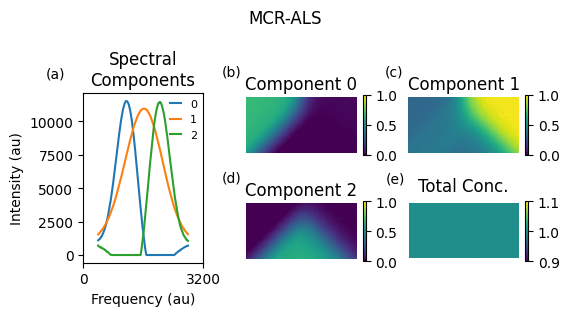

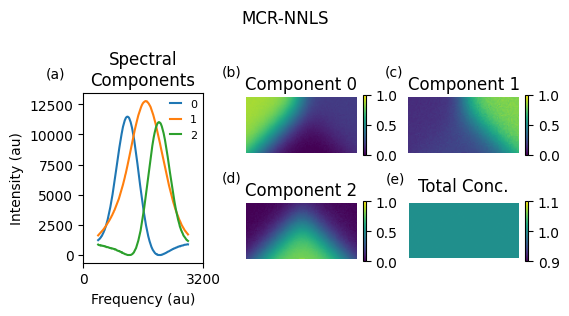

In [17]:
    
# Loop over each method in the method_list using its index (mcr_select)
for mcr_select in range(len(method_list)):
    
    # Create a new figure with a specified size (width=5.5 inches, height=4 inches)
    plt.figure(figsize=(5.5,4))
    
    # Define a subplot within a 4x3 grid, positioned at row 1, column 0, spanning 2 rows
    plt.subplot2grid((4,3), loc=[1,0], rowspan=2)
    
    # Plot the first spectral component (index select[0]) against the wavenumber (wn)
    plt.plot(wn, mcr[mcr_select].ST_opt_[select[0]], label='0')
    
    # Plot the second spectral component (index select[1]) against the wavenumber (wn)
    plt.plot(wn, mcr[mcr_select].ST_opt_[select[1]], label='1')
    
    # Plot the third spectral component (index select[2]) against the wavenumber (wn)
    plt.plot(wn, mcr[mcr_select].ST_opt_[select[2]], label='2')
    
    # Label the x-axis as 'Frequency (au)'
    plt.xlabel('Frequency (au)')
    
    # Label the y-axis as 'Intensity (au)'
    plt.ylabel('Intensity (au)')
    
    # Add a legend to the plot located at the upper right, without a frame, minimal padding, and short handles
    plt.legend(loc='upper right', frameon=False, borderpad=0, handlelength=1)
    
    # Set the title of the subplot as 'Spectral\nComponents', with a newline between words
    plt.title('Spectral\nComponents')
    
    # (Optional) Set the x-axis limits from 0 to 3000; currently commented out
    # plt.axis(xmin=0, xmax=3000)
    
    # Set the x-ticks to show only at 0 and 3200
    plt.xticks((0, 3200))
    
    # Add text '(a)' at position (-1000, 1.1 * max y-axis value) to label the subplot
    plt.text(-1000, 1.1*plt.axis()[-1], '(a)')
    
    # Define a new subplot in the 4x3 grid at row 1, column 1, spanning 1 row
    plt.subplot2grid((4,3), loc=[1,1], rowspan=1)
    
    # Display an image of the first concentration map, reshaped to match the original concentration shape
    # 'clim' sets the color limits from 0 to 1
    plt.imshow(mcr[mcr_select].C_opt_[..., select[0]].reshape(*conc[...,0].shape), clim=[0,1])
    
    # Add a colorbar to the image with a fraction of the original size (height)
    plt.colorbar(fraction=0.025)
    
    # Hide the axis ticks and labels
    plt.axis('off')
    
    # Set the title of the subplot as 'Component 0'
    plt.title('Component {}'.format(0))
    
    # Add text '(b)' at position (-22, -20) to label the subplot
    plt.text(-22, -20, '(b)')
    
    # Define another subplot at row 1, column 2, spanning 1 row
    plt.subplot2grid((4,3), loc=[1,2], rowspan=1)
    
    # Display an image of the second concentration map with the same reshaping and color limits
    plt.imshow(mcr[mcr_select].C_opt_[..., select[1]].reshape(*conc[...,0].shape), clim=[0,1])
    
    # Add a colorbar to the image
    plt.colorbar(fraction=0.025)
    
    # Hide the axis ticks and labels
    plt.axis('off')
    
    # Set the title of the subplot as 'Component 1'
    plt.title('Component {}'.format(1))
    
    # Add text '(c)' at position (-22, -20) to label the subplot
    plt.text(-22, -20, '(c)')
    
    # Define a new subplot at row 2, column 1, spanning 1 row
    plt.subplot2grid((4,3), loc=[2,1], rowspan=1)
    
    # Display an image of the third concentration map with reshaping and color limits
    plt.imshow(mcr[mcr_select].C_opt_[..., select[2]].reshape(*conc[...,0].shape), clim=[0,1])
    
    # Add a colorbar to the image
    plt.colorbar(fraction=0.025)
    
    # Hide the axis ticks and labels
    plt.axis('off')
    
    # Set the title of the subplot as 'Component 2'
    plt.title('Component {}'.format(2))
    
    # Add text '(d)' at position (-22, -20) to label the subplot
    plt.text(-22, -20, '(d)')
    
    # Define another subplot at row 2, column 2, spanning 1 row
    plt.subplot2grid((4,3), loc=[2,2], rowspan=1)
    
    # Display an image of the total concentration by summing over all components
    # 'clim' sets the color limits from 0.9 to 1.1 to highlight deviations
    plt.imshow(mcr[mcr_select].C_opt_.sum(axis=-1).reshape(*conc[...,0].shape), clim=[0.9, 1.1])
    
    # (Optional) Alternative way to display the total concentration from the original data; currently commented out
    # plt.imshow(conc.sum(axis=-1), clim=[0.9, 1.1])
    
    # Add a colorbar to the image
    plt.colorbar(fraction=0.025)
    
    # Hide the axis ticks and labels
    plt.axis('off')
    
    # Set equal scaling by changing the axis aspect ratio to 'equal'
    plt.axis('equal')
    
    # Set the title of the subplot as 'Total Conc.'
    plt.title('Total Conc.')
    
    # Add text '(e)' at position (-22, -20) to label the subplot
    plt.text(-22, -20, '(e)')
    
    # Add a super title to the entire figure using the current method's name from method_list
    st = plt.suptitle(method_list[mcr_select])
    
    # Adjust the vertical position of the super title to 90% of the figure height
    st.set_y(0.9)
    
    # Adjust the layout of the figure to prevent overlapping elements
    # 'pad=0' sets padding around the figure
    # 'h_pad=0' and 'w_pad=-1' set horizontal and vertical padding between subplots
    plt.tight_layout(pad=0, h_pad=0, w_pad=-1)
    
    # If the SAVEFIG flag is True, save the figure to a file with a formatted filename
    if SAVEFIG:
        plt.savefig('./{}_{}_{}_Conc_Spectra_Compound.png'.format(date_prefix, fig_prefix, method_list[mcr_select]))
    
    # Display the figure
    plt.show()
    